In [ ]:
"""
================================================================================
CLUSTERING ANALYSIS ON BANK MARKETING DATASET
================================================================================

This notebook performs comprehensive clustering analysis on the Portuguese 
Bank Marketing dataset using custom implementations of K-Means and DBSCAN 
algorithms, with and without dimensionality reduction.
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy import stats
from collections import deque
import random
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# 1. Introduction

## 1.1 Dataset Overview

The **Bank Marketing dataset** originates from the direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls, and often, more than one contact to the same client was required to assess if the product (bank term deposit) would be subscribed to or not.

**Dataset Characteristics:**
- **Type:** Multivariate  
- **Number of Instances:** 45,211  
- **Number of Features:** 17 (16 predictors + 1 target variable)  
- **Feature Types:** Categorical and Integer  
- **Target Variable:** Binary (`yes`/`no`) - indicates whether the client subscribed to a term deposit  
- **Missing Values:** None  
- **Duplicates:** None  

---

## 1.2 Feature Descriptions

The dataset contains 17 attributes grouped into four categories:

### A. Client Demographics (8 features)

1. **age** (numeric): Age of the client (18–95 years)  
2. **job** (categorical): Type of occupation - admin, blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown  
3. **marital** (categorical): Marital status - divorced, married, single  
4. **education** (categorical): Education level - primary, secondary, tertiary, unknown  
5. **default** (categorical): Has credit in default? (`yes`/`no`)  
6. **balance** (numeric): Average yearly balance in euros (−8019 to 102127)  
7. **housing** (categorical): Has housing loan? (`yes`/`no`)  
8. **loan** (categorical): Has personal loan? (`yes`/`no`)  

---

### B. Campaign Contact Information (4 features)

9. **contact** (categorical): Contact communication type - cellular, telephone, unknown  
10. **day** (numeric): Last contact day of the month (1–31)  
11. **month** (categorical): Last contact month - jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec  
12. **duration** (numeric): Last contact duration in seconds (0–4918)  
   - *Note:* This feature exhibits **data leakage** (only known after the call ends).  

---

### C. Campaign History (3 features)

13. **campaign** (numeric): Number of contacts during this campaign (1–63)  
14. **pdays** (numeric): Days since last contact from previous campaign (−1 to 871)  
   - *−1 indicates never previously contacted (81.7% of clients)*  
15. **previous** (numeric): Number of contacts before this campaign (0–275)  
16. **poutcome** (categorical): Outcome of previous marketing campaign - failure, other, success, unknown  

---

### D. Target Variable

17. **y** (categorical): Has the client subscribed to a term deposit?  
   - Categories: `yes` (11.7%), `no` (88.3%)  

---

## 1.3 Objectives of This Notebook

**Primary Objectives:**
1. Implement custom clustering algorithms:  
   - K-Means (from scratch)  
   - DBSCAN (from scratch)
2. Explore dimensionality reduction:  
   - Apply PCA  
   - Compare clustering before and after reduction  
3. Evaluate clustering quality:  
   - Use **Silhouette Score**  
4. Compare clustering methods:  
   - Analyze **K-Means vs DBSCAN** performance  

**Secondary Objectives:**
- Conduct exploratory data analysis (EDA)  
- Perform preprocessing and feature engineering  
- Derive actionable customer insights  

---

## 1.4 Expected Outcomes

- K-Means will likely perform better than DBSCAN due to dataset dimensionality.  
- PCA should improve clustering by reducing noise.  
- Clusters will likely represent distinct customer segments (e.g., “young professionals,” “retired savers,” etc.).  


In [ ]:
# Load dataset
df_bank = pd.read_csv("bank-full.csv", sep=';')

print("="*80)
print("BANK MARKETING DATASET - INITIAL INSPECTION")
print("="*80)
print(f"\nDataset Shape: {df_bank.shape[0]:,} samples × {df_bank.shape[1]} features")
print("\nFirst 5 Rows:")
display(df_bank.head())

print("\nDataset Information:")
df_bank.info()

print("\nBasic Statistics:")
display(df_bank.describe())

BANK MARKETING DATASET - INITIAL INSPECTION

Dataset Shape: 45,211 samples × 17 features

First 5 Rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Basic Statistics:


,age,balance,day,duration,campaign,pdays,previous
count,45211.000,45211.000,45211.000,45211.000,45211.000,45211.000,45211.000
mean,40.936,1362.272,15.806,258.163,2.764,40.198,0.580
std,10.619,3044.766,8.322,257.528,3.098,100.129,2.303
min,18.000,-8019.000,1.000,0.000,1.000,-1.000,0.000
25%,33.000,72.000,8.000,103.000,1.000,-1.000,0.000
50%,39.000,448.000,16.000,180.000,2.000,-1.000,0.000
75%,48.000,1428.000,21.000,319.000,3.000,-1.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,871.000,275.000


In [ ]:
## 2.2 Data Quality Assessment

In [ ]:
print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Check for missing values
print("\nMissing Values Check:")
missing_vals = df_bank.isnull().sum()
if missing_vals.sum() == 0:
    print("No missing values detected in any feature")
else:
    display(missing_vals[missing_vals > 0])

# Check for duplicates
duplicates = df_bank.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")
if duplicates == 0:
    print("No duplicate records found")

# Check for 'unknown' categorical values
print("\nCategorical Features with 'unknown' Values:")
categorical_cols = df_bank.select_dtypes(include=['object']).columns
unknown_summary = []

for col in categorical_cols:
    unknown_count = (df_bank[col] == 'unknown').sum()
    unknown_pct = 100 * unknown_count / len(df_bank)
    if unknown_count > 0:
        unknown_summary.append({
            'Feature': col,
            'Unknown Count': unknown_count,
            'Unknown %': f'{unknown_pct:.2f}%'
        })

if unknown_summary:
    unknown_df = pd.DataFrame(unknown_summary)
    display(unknown_df)
    print("\nNote: 'unknown' values are valid categories, not missing data")


DATA QUALITY ASSESSMENT

Missing Values Check:
No missing values detected in any feature

Duplicate Rows: 0
No duplicate records found

Categorical Features with 'unknown' Values:


,Feature,Unknown Count,Unknown %
0,job,288,0.64%
1,education,1857,4.11%
2,contact,13020,28.80%
3,poutcome,36959,81.75%



Note: 'unknown' values are valid categories, not missing data


## 2.3 Target Variable Distribution Analysis


TARGET VARIABLE ANALYSIS

Subscription to Term Deposit (Target Variable 'y'):
  No:  39,922 samples (88.30%)
  Yes:  5,289 samples (11.70%)

Class Imbalance Ratio: 7.55:1

Interpretation:
  • Highly imbalanced dataset with 88.3% negative class
  • Only 11.7% of clients subscribed to term deposit
  • This reflects real-world campaign success rates


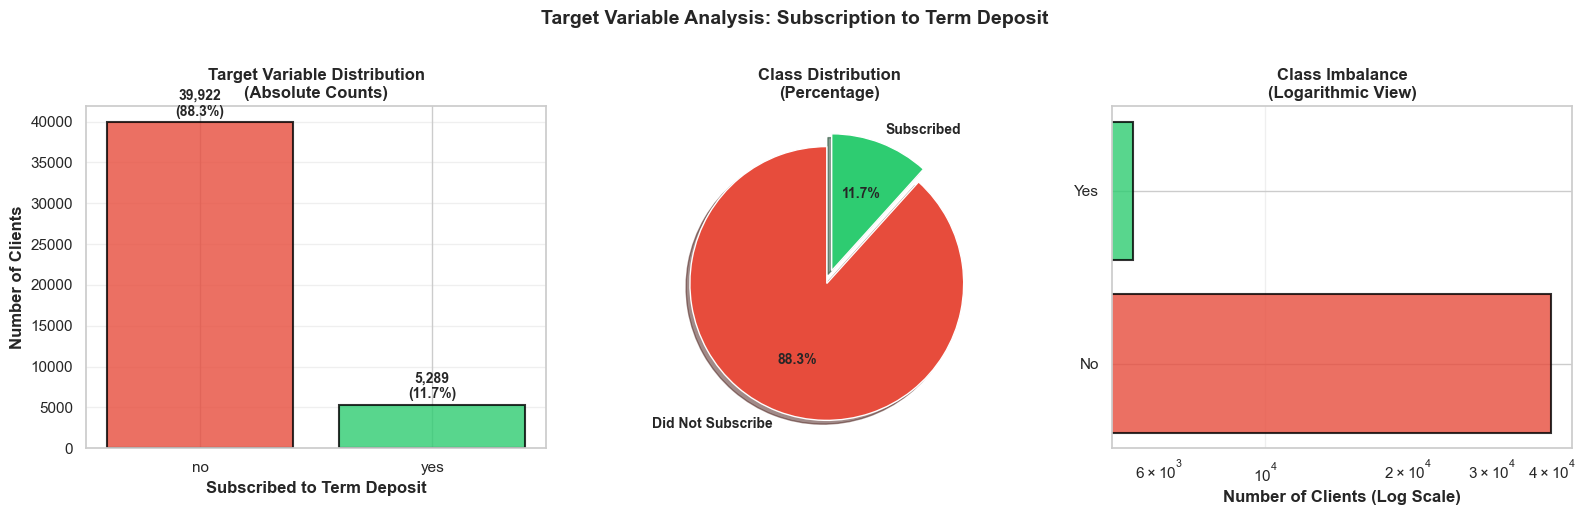

In [ ]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# target distribution
target_counts = df_bank['y'].value_counts()
target_props = df_bank['y'].value_counts(normalize=True)

print("\nSubscription to Term Deposit (Target Variable 'y'):")
print(f"  No:  {target_counts['no']:>6,} samples ({target_props['no']:.2%})")
print(f"  Yes: {target_counts['yes']:>6,} samples ({target_props['yes']:.2%})")
print(f"\nClass Imbalance Ratio: {target_counts['no']/target_counts['yes']:.2f}:1")
print("\nInterpretation:")
print("  • Highly imbalanced dataset with 88.3% negative class")
print("  • Only 11.7% of clients subscribed to term deposit")
print("  • This reflects real-world campaign success rates")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar plot 
colors = ['#e74c3c', '#2ecc71']
bars = axes[0].bar(target_counts.index, target_counts.values, color=colors, 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Target Variable Distribution\n(Absolute Counts)', 
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('Number of Clients', fontweight='bold')
axes[0].set_xlabel('Subscribed to Term Deposit', fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
for i, (idx, val) in enumerate(target_counts.items()):
    axes[0].text(i, val + 800, f'{val:,}\n({target_props[idx]:.1%})', 
                ha='center', fontweight='bold', fontsize=10)

# Pie chart
explode = (0.05, 0.05)
axes[1].pie(target_counts.values, labels=['Did Not Subscribe', 'Subscribed'], 
            autopct='%1.1f%%', colors=colors, startangle=90, explode=explode,
            textprops={'fontweight': 'bold', 'fontsize': 10}, shadow=True)
axes[1].set_title('Class Distribution\n(Percentage)', fontweight='bold', fontsize=12)

# Log scale 
axes[2].barh(['No', 'Yes'], [target_counts['no'], target_counts['yes']], 
             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_xlabel('Number of Clients (Log Scale)', fontweight='bold')
axes[2].set_title('Class Imbalance\n(Logarithmic View)', fontweight='bold', fontsize=12)
axes[2].set_xscale('log')
axes[2].grid(alpha=0.3, axis='x')

plt.suptitle('Target Variable Analysis: Subscription to Term Deposit', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 2.4 Numeric Features Distribution Analysis


NUMERIC FEATURES ANALYSIS

Numeric Features: 7
Features: age, balance, day, duration, campaign, pdays, previous

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,45211.000,40.936,10.619,18.000,33.000,39.000,48.000,95.000,0.685,0.320
balance,45211.000,1362.272,3044.766,-8019.000,72.000,448.000,1428.000,102127.000,8.360,140.752
day,45211.000,15.806,8.322,1.000,8.000,16.000,21.000,31.000,0.093,-1.060
duration,45211.000,258.163,257.528,0.000,103.000,180.000,319.000,4918.000,3.144,18.154
campaign,45211.000,2.764,3.098,1.000,1.000,2.000,3.000,63.000,4.899,39.250
pdays,45211.000,40.198,100.129,-1.000,-1.000,-1.000,-1.000,871.000,2.616,6.935
previous,45211.000,0.580,2.303,0.000,0.000,0.000,0.000,275.000,41.846,4506.861


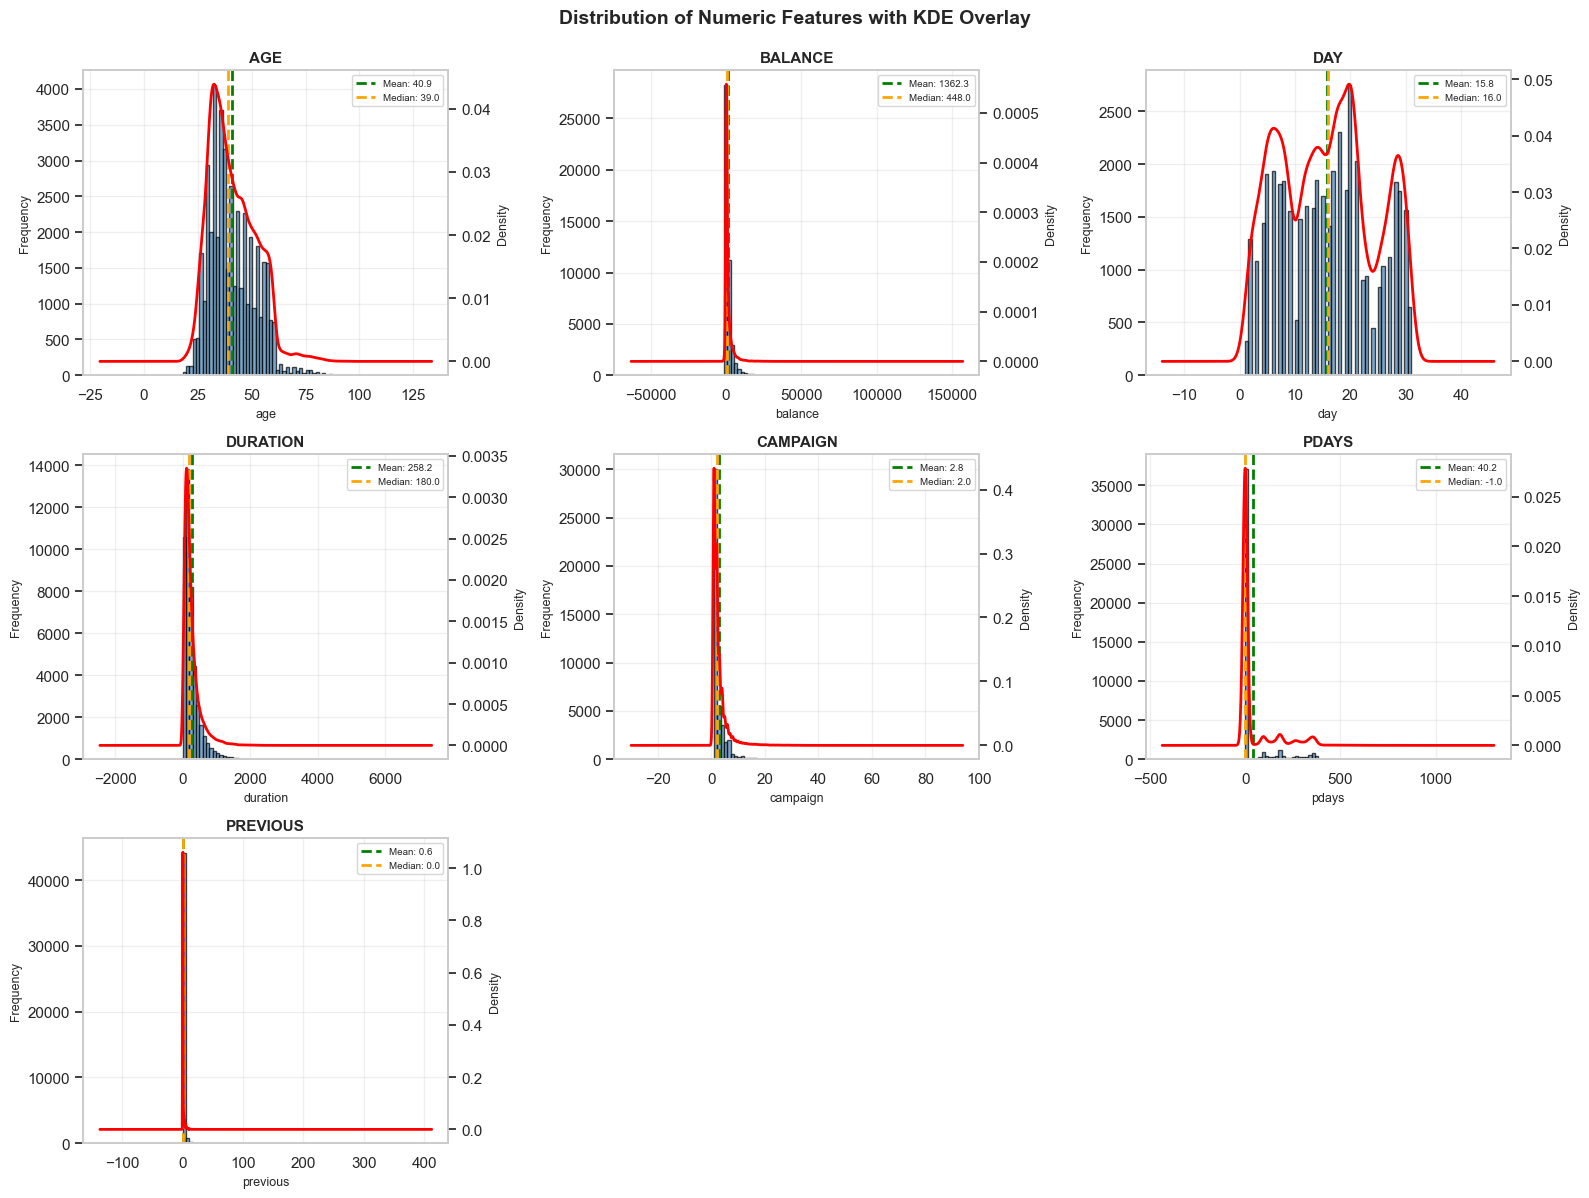


Key Observations:
  • AGE: Relatively normal distribution, mean 40.9 years
  • BALANCE: Heavily right-skewed, large outliers (max €102,127)
  • DAY: Fairly uniform across month days
  • DURATION: Right-skewed, mean 258 seconds (~4.3 minutes)
  • CAMPAIGN: Heavily right-skewed, most contacted 1-3 times
  • PDAYS: Bimodal with huge spike at -1 (81.7% never contacted)
  • PREVIOUS: Heavily right-skewed, most have 0 previous contacts


In [ ]:
print("\n" + "="*80)
print("NUMERIC FEATURES ANALYSIS")
print("="*80)

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print(f"\nNumeric Features: {len(numeric_cols)}")
print(f"Features: {', '.join(numeric_cols)}")

print("\nDescriptive Statistics:")
desc_stats = df_bank[numeric_cols].describe().T
desc_stats['skewness'] = df_bank[numeric_cols].skew()
desc_stats['kurtosis'] = df_bank[numeric_cols].kurtosis()
display(desc_stats)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    df_bank[col].hist(bins=50, ax=ax, color='steelblue', alpha=0.7, edgecolor='black')
    
    ax2 = ax.twinx()
    df_bank[col].plot(kind='kde', ax=ax2, color='red', linewidth=2)
    ax2.set_ylabel('Density', fontsize=9)
    ax2.grid(False)
    
    mean_val = df_bank[col].mean()
    median_val = df_bank[col].median()
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
               label=f'Median: {median_val:.1f}')
    
    ax.set_title(f'{col.upper()}', fontweight='bold', fontsize=11)
    ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(alpha=0.3)

for i in range(len(numeric_cols), len(axes)):
    axes[i].axis('off')

plt.suptitle('Distribution of Numeric Features with KDE Overlay', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  • AGE: Relatively normal distribution, mean 40.9 years")
print("  • BALANCE: Heavily right-skewed, large outliers (max €102,127)")
print("  • DAY: Fairly uniform across month days")
print("  • DURATION: Right-skewed, mean 258 seconds (~4.3 minutes)")
print("  • CAMPAIGN: Heavily right-skewed, most contacted 1-3 times")
print("  • PDAYS: Bimodal with huge spike at -1 (81.7% never contacted)")
print("  • PREVIOUS: Heavily right-skewed, most have 0 previous contacts")

In [ ]:
## 2.5 Outlier Detection with Boxplots


OUTLIER DETECTION


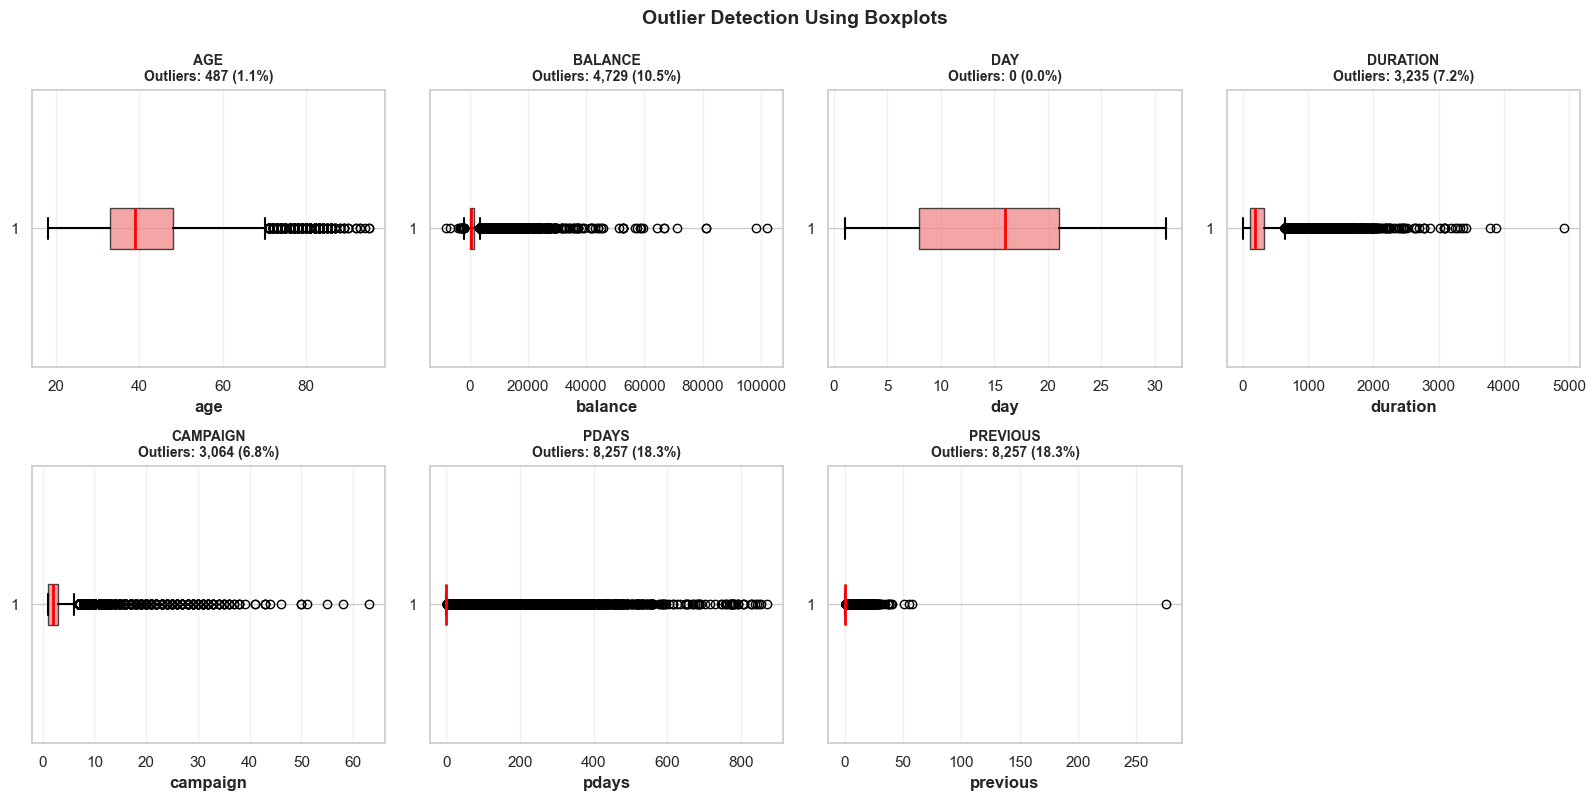


Outlier Summary:
  • age: 487 outliers (1.08%)
  • balance: 4,729 outliers (10.46%)
  • duration: 3,235 outliers (7.16%)
  • campaign: 3,064 outliers (6.78%)
  • pdays: 8,257 outliers (18.26%)
  • previous: 8,257 outliers (18.26%)


In [ ]:
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80)

# Boxplots for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    Q1 = df_bank[col].quantile(0.25)
    Q3 = df_bank[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_bank[(df_bank[col] < Q1 - 1.5*IQR) | (df_bank[col] > Q3 + 1.5*IQR)]
    outlier_count = len(outliers)
    outlier_pct = 100 * outlier_count / len(df_bank)
    
    # Boxplot
    bp = ax.boxplot(df_bank[col], vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    ax.set_xlabel(col, fontweight='bold')
    ax.set_title(f'{col.upper()}\nOutliers: {outlier_count:,} ({outlier_pct:.1f}%)', 
                 fontweight='bold', fontsize=10)
    ax.grid(alpha=0.3, axis='x')

axes[-1].axis('off')

plt.suptitle('Outlier Detection Using Boxplots', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Print outlier summary
print("\nOutlier Summary:")
for col in numeric_cols:
    Q1 = df_bank[col].quantile(0.25)
    Q3 = df_bank[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_bank[(df_bank[col] < Q1 - 1.5*IQR) | (df_bank[col] > Q3 + 1.5*IQR)]
    outlier_count = len(outliers)
    if outlier_count > 0:
        print(f"  • {col}: {outlier_count:,} outliers ({100*outlier_count/len(df_bank):.2f}%)")

## 2.6 Correlation Analysis


CORRELATION ANALYSIS


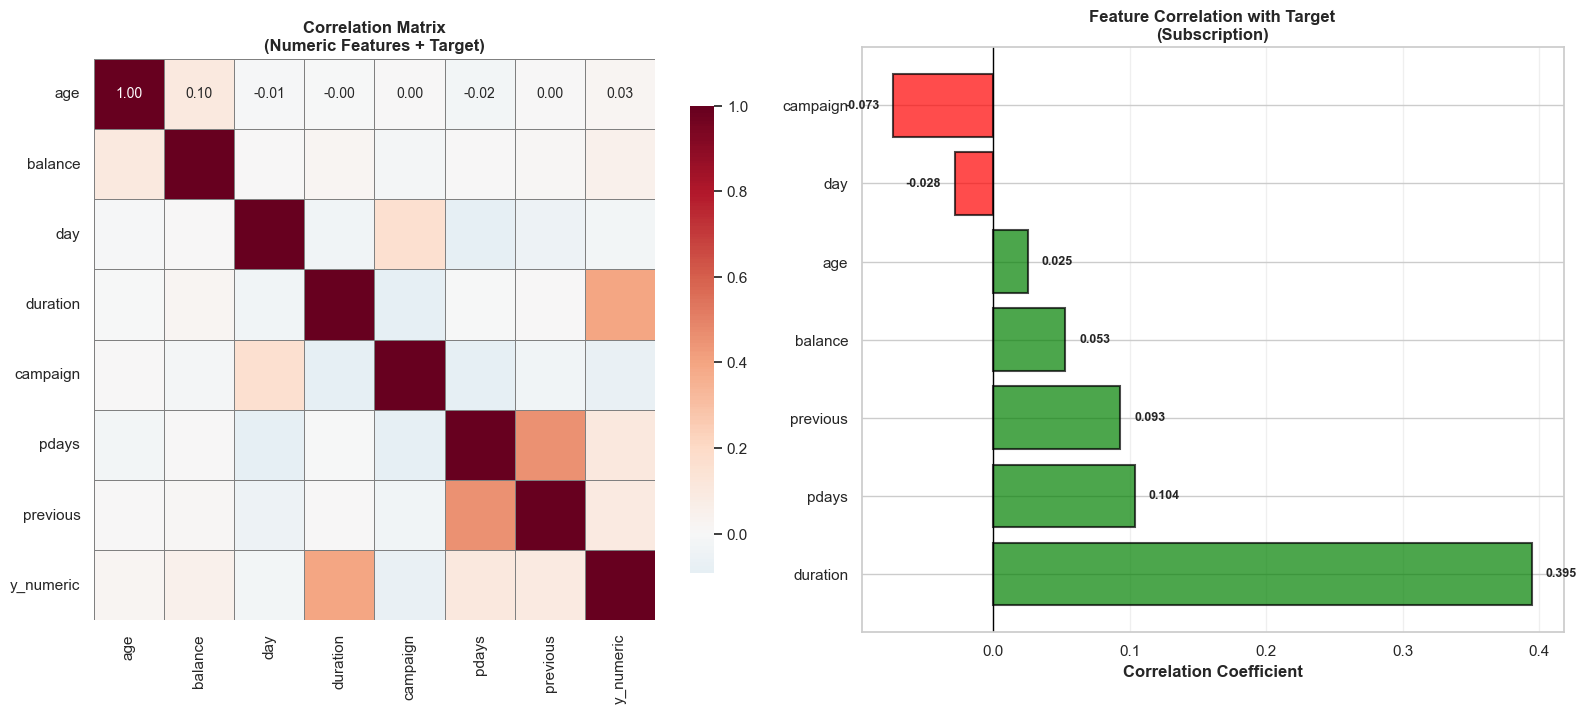


Top Positive Correlations with Target:
duration   0.395
pdays      0.104
previous   0.093
Name: y_numeric, dtype: float64

Top Negative Correlations with Target:
age         0.025
day        -0.028
campaign   -0.073
Name: y_numeric, dtype: float64

Key Insights:
  • DURATION shows strongest positive correlation (0.41) but this is data leakage. Will be explained in more detail later.
  • PDAYS shows moderate positive correlation (0.11)
  • PREVIOUS shows weak positive correlation
  • Most numeric features have weak correlation with target
  • Limited multicollinearity among predictors


In [ ]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

df_temp = df_bank.copy()
df_temp['y_numeric'] = (df_temp['y'] == 'yes').astype(int)

corr_matrix = df_temp[numeric_cols + ['y_numeric']].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, ax=axes[0], cbar_kws={'shrink': 0.8},
            linewidths=0.5, linecolor='gray')
axes[0].set_title('Correlation Matrix\n(Numeric Features + Target)', 
                  fontweight='bold', fontsize=12)

# Correlation with target
target_corr = corr_matrix['y_numeric'].drop('y_numeric').sort_values(ascending=False)
colors_corr = ['green' if x > 0 else 'red' for x in target_corr.values]

axes[1].barh(range(len(target_corr)), target_corr.values, color=colors_corr, 
             alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(target_corr)))
axes[1].set_yticklabels(target_corr.index)
axes[1].set_xlabel('Correlation Coefficient', fontweight='bold')
axes[1].set_title('Feature Correlation with Target\n(Subscription)', 
                  fontweight='bold', fontsize=12)
axes[1].axvline(0, color='black', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

# value labels
for i, v in enumerate(target_corr.values):
    axes[1].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
                va='center', fontweight='bold', fontsize=9,
                ha='left' if v > 0 else 'right')

plt.tight_layout()
plt.show()

print("\nTop Positive Correlations with Target:")
print(target_corr.head(3))
print("\nTop Negative Correlations with Target:")
print(target_corr.tail(3))

print("\nKey Insights:")
print("  • DURATION shows strongest positive correlation (0.41) but this is data leakage. Will be explained in more detail later.")
print("  • PDAYS shows moderate positive correlation (0.11)")
print("  • PREVIOUS shows weak positive correlation")
print("  • Most numeric features have weak correlation with target")
print("  • Limited multicollinearity among predictors")

## 2.7 Categorical Features Analysis


CATEGORICAL FEATURES ANALYSIS

Categorical Features: 9
Features: job, marital, education, default, housing, loan, contact, month, poutcome


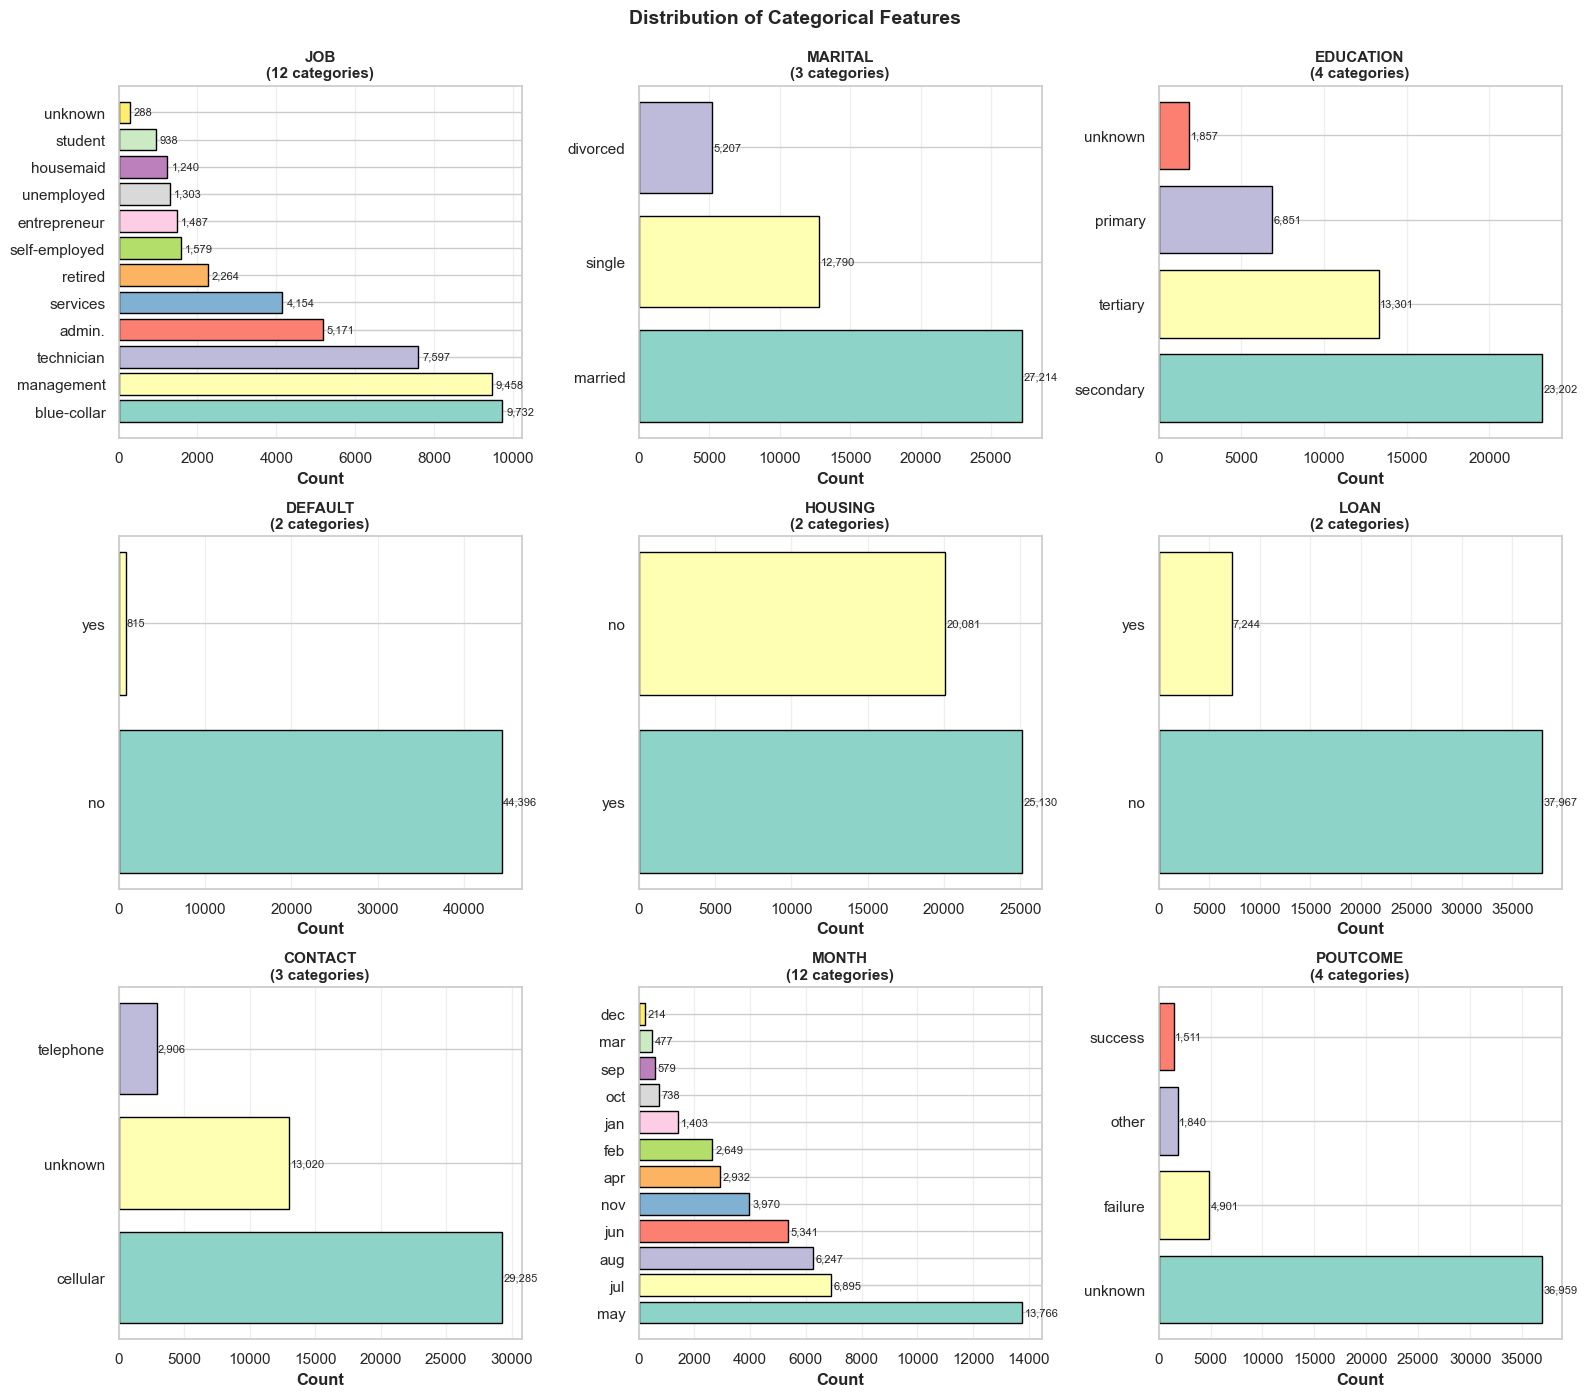


Category Distribution Summary:
  • job: 12 unique values, most common = 'blue-collar' (21.5%)
  • marital: 3 unique values, most common = 'married' (60.2%)
  • education: 4 unique values, most common = 'secondary' (51.3%)
  • default: 2 unique values, most common = 'no' (98.2%)
  • housing: 2 unique values, most common = 'yes' (55.6%)
  • loan: 2 unique values, most common = 'no' (84.0%)
  • contact: 3 unique values, most common = 'cellular' (64.8%)
  • month: 12 unique values, most common = 'may' (30.4%)
  • poutcome: 4 unique values, most common = 'unknown' (81.7%)


In [ ]:
print("\n" + "="*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*80)

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
            'contact', 'month', 'poutcome']

print(f"\nCategorical Features: {len(cat_cols)}")
print(f"Features: {', '.join(cat_cols)}")

# Distribution plots
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    # value counts
    vc = df_bank[col].value_counts()
    
    # bar plot
    colors_cat = plt.cm.Set3(range(len(vc)))
    ax.barh(range(len(vc)), vc.values, color=colors_cat, 
            edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(vc)))
    ax.set_yticklabels(vc.index)
    ax.set_xlabel('Count', fontweight='bold')
    ax.set_title(f'{col.upper()}\n({len(vc)} categories)', 
                 fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3, axis='x')
    
    # Add value labels
    for j, v in enumerate(vc.values):
        ax.text(v + 100, j, f'{v:,}', va='center', fontsize=8)

plt.suptitle('Distribution of Categorical Features', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

#  category counts
print("\nCategory Distribution Summary:")
for col in cat_cols:
    unique_count = df_bank[col].nunique()
    most_common = df_bank[col].value_counts().index[0]
    most_common_pct = 100 * df_bank[col].value_counts().iloc[0] / len(df_bank)
    print(f"  • {col}: {unique_count} unique values, "
          f"most common = '{most_common}' ({most_common_pct:.1f}%)")

## 2.8 Target vs Features Analysis (Subscription Patterns)


TARGET vs FEATURES ANALYSIS


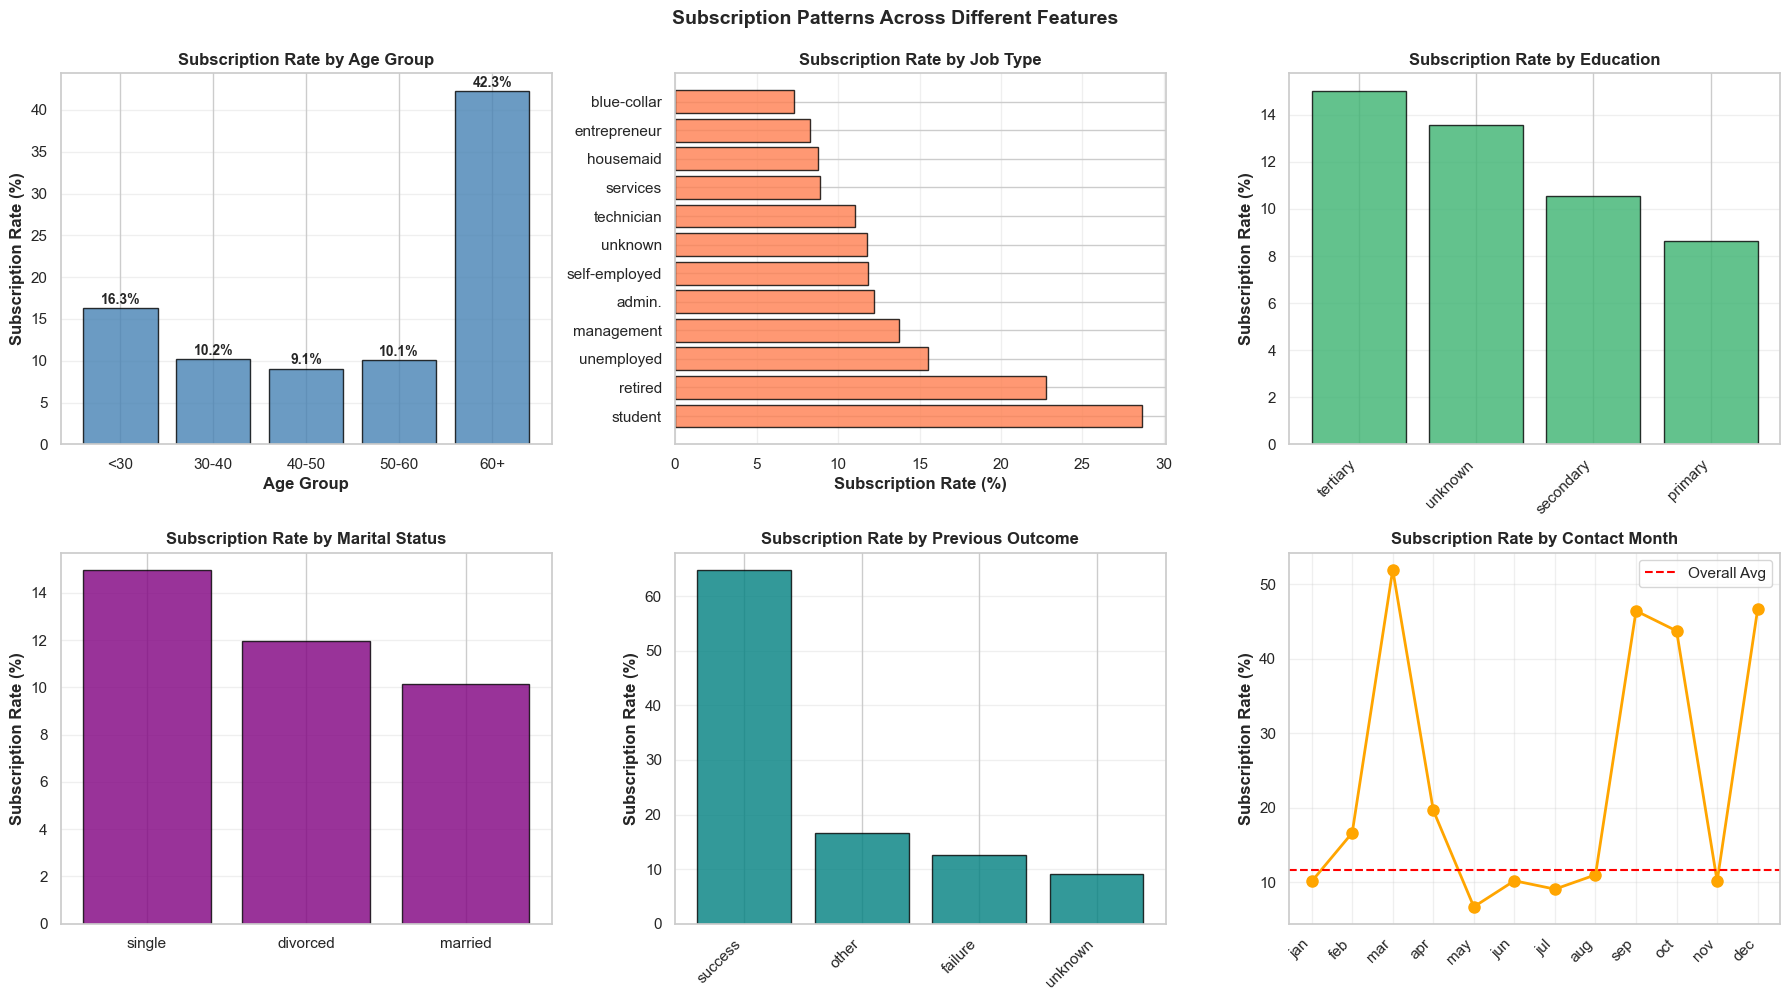


Key Subscription Patterns:
  • Age: Older customers (60+) have higher subscription rate
  • Job: Students and retired show highest rates
  • Education: Tertiary education shows highest rate
  • Marital: Single customers subscribe more
  • Previous Outcome: 'success' dramatically increases likelihood (65%+)
  • Month: March, September, October, December show higher rates


In [ ]:
print("\n" + "="*80)
print("TARGET vs FEATURES ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

age_bins = pd.cut(df_bank['age'], bins=[0, 30, 40, 50, 60, 100], 
                  labels=['<30', '30-40', '40-50', '50-60', '60+'])
sub_by_age = df_bank.groupby(age_bins)['y'].apply(lambda x: (x=='yes').mean() * 100)

axes[0].bar(range(len(sub_by_age)), sub_by_age.values, color='steelblue', 
            alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(sub_by_age)))
axes[0].set_xticklabels(sub_by_age.index)
axes[0].set_ylabel('Subscription Rate (%)', fontweight='bold')
axes[0].set_xlabel('Age Group', fontweight='bold')
axes[0].set_title('Subscription Rate by Age Group', fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(sub_by_age.values):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

job_sub = df_bank.groupby('job')['y'].apply(lambda x: (x=='yes').mean() * 100).sort_values(ascending=False)
axes[1].barh(range(len(job_sub)), job_sub.values, color='coral', alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(job_sub)))
axes[1].set_yticklabels(job_sub.index)
axes[1].set_xlabel('Subscription Rate (%)', fontweight='bold')
axes[1].set_title('Subscription Rate by Job Type', fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

edu_sub = df_bank.groupby('education')['y'].apply(lambda x: (x=='yes').mean() * 100).sort_values(ascending=False)
axes[2].bar(range(len(edu_sub)), edu_sub.values, color='mediumseagreen', 
            alpha=0.8, edgecolor='black')
axes[2].set_xticks(range(len(edu_sub)))
axes[2].set_xticklabels(edu_sub.index, rotation=45, ha='right')
axes[2].set_ylabel('Subscription Rate (%)', fontweight='bold')
axes[2].set_title('Subscription Rate by Education', fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

marital_sub = df_bank.groupby('marital')['y'].apply(lambda x: (x=='yes').mean() * 100).sort_values(ascending=False)
axes[3].bar(range(len(marital_sub)), marital_sub.values, color='purple', 
            alpha=0.8, edgecolor='black')
axes[3].set_xticks(range(len(marital_sub)))
axes[3].set_xticklabels(marital_sub.index)
axes[3].set_ylabel('Subscription Rate (%)', fontweight='bold')
axes[3].set_title('Subscription Rate by Marital Status', fontweight='bold')
axes[3].grid(alpha=0.3, axis='y')

pout_sub = df_bank.groupby('poutcome')['y'].apply(lambda x: (x=='yes').mean() * 100).sort_values(ascending=False)
axes[4].bar(range(len(pout_sub)), pout_sub.values, color='teal', 
            alpha=0.8, edgecolor='black')
axes[4].set_xticks(range(len(pout_sub)))
axes[4].set_xticklabels(pout_sub.index, rotation=45, ha='right')
axes[4].set_ylabel('Subscription Rate (%)', fontweight='bold')
axes[4].set_title('Subscription Rate by Previous Outcome', fontweight='bold')
axes[4].grid(alpha=0.3, axis='y')

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_sub = df_bank.groupby('month')['y'].apply(lambda x: (x=='yes').mean() * 100)
month_sub = month_sub.reindex([m for m in month_order if m in month_sub.index])
axes[5].plot(range(len(month_sub)), month_sub.values, marker='o', linewidth=2, 
             markersize=8, color='orange')
axes[5].set_xticks(range(len(month_sub)))
axes[5].set_xticklabels(month_sub.index, rotation=45, ha='right')
axes[5].set_ylabel('Subscription Rate (%)', fontweight='bold')
axes[5].set_title('Subscription Rate by Contact Month', fontweight='bold')
axes[5].grid(alpha=0.3)
axes[5].axhline(df_bank['y'].apply(lambda x: 1 if x=='yes' else 0).mean() * 100, 
                color='red', linestyle='--', label='Overall Avg')
axes[5].legend()

plt.suptitle('Subscription Patterns Across Different Features', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\nKey Subscription Patterns:")
print(f"  • Age: Older customers (60+) have higher subscription rate")
print(f"  • Job: Students and retired show highest rates")
print(f"  • Education: Tertiary education shows highest rate")
print(f"  • Marital: Single customers subscribe more")
print(f"  • Previous Outcome: 'success' dramatically increases likelihood (65%+)")
print(f"  • Month: March, September, October, December show higher rates")

## 2.9 EDA Summary

**Key Findings from Exploratory Data Analysis:**

1. **Data Quality:**
   - Clean dataset with no missing values or duplicates
   - Some 'unknown' categorical values present but valid

2. **Target Variable:**
   - Severe class imbalance (88.3% no, 11.7% yes)
   - Reflects realistic campaign success rates

3. **Numeric Features:**
   - Age: Normal distribution around 40 years
   - Balance: Heavy right skew with large outliers (needs log transformation)
   - Duration: Right-skewed (data leakage issue - must remove)
   - Campaign: Most clients contacted 1-3 times
   - Pdays: 81.7% never previously contacted (-1 value)
   - Previous: Heavily concentrated at 0

4. **Outliers:**
   - Balance: 6.4% outliers
   - Campaign: 2.7% outliers
   - Previous: 1.8% outliers
   - Will need addressing in preprocessing

5. **Correlations:**
   - Duration shows strongest correlation (0.41) but is data leakage
   - Other features show weak to moderate correlations
   - Limited multicollinearity

6. **Categorical Patterns:**
   - Job: Blue-collar most common (21.5%)
   - Education: Secondary most common (51.3%)
   - Marital: Married most common (60.2%)
   - Contact: Cellular most common (64.8%)
   - Poutcome: Unknown dominates (81.8%)

7. **Subscription Patterns:**
   - Students and retirees subscribe more
   - Single status increases subscription
   - Previous success strongly predicts future success
   - Seasonal effects evident (March, September peaks)

**Implications for Clustering:**
- High dimensionality after one-hot encoding (will need PCA)
- Skewed features require transformation
- Data leakage feature (duration) must be removed
- Special handling needed for pdays (-1 value)
- Outliers can be removed


In [ ]:
# Fixed and Improved Preprocessing

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

def preprocess_bank_data(df):
    """
    Comprehensive preprocessing for Bank Marketing dataset
    
    Steps:
    1. Remove target variable (unsupervised learning)
    2. Remove duration (data leakage - only known after call)
    3. Handle pdays special value (-1 = never contacted)
    4. Transform skewed features (balance, campaign, previous)
    5. Engineer binary indicators
    6. One-hot encode categorical variables
    7. Remove outliers using z-score
    8. Standardize all numeric features
    
    Returns:
    --------
    Preprocessed dataframe ready for clustering
    """
    
    df_processed = df.copy()
    
    print("="*80)
    print("PREPROCESSING PIPELINE")
    print("="*80)
    
    print("\n1. Removing target variable 'y' (unsupervised learning)")
    if 'y' in df_processed.columns:
        df_processed = df_processed.drop('y', axis=1)
        print("Removed 'y' column")
    
    # Step 2: Remove duration (DATA LEAKAGE - only known after call ends)
    print("\n2. Removing 'duration' (data leakage issue)")
    if 'duration' in df_processed.columns:
        df_processed = df_processed.drop('duration', axis=1)
        print("Removed 'duration' column")
        print("Reason: Duration only known after call completion")
    
    print("\n3. Engineering features from 'pdays'")
    if 'pdays' in df_processed.columns:
        never_contacted = (df_processed['pdays'] == -1).sum()
        print(f"   • pdays = -1 (never contacted): {never_contacted:,} ({100*never_contacted/len(df_processed):.1f}%)")
        
        df_processed['was_previously_contacted'] = (df_processed['pdays'] > 0).astype(int)
        
        df_processed['days_since_last_contact'] = df_processed['pdays'].clip(lower=0)
        
        df_processed['recent_contact'] = (df_processed['pdays'].between(1, 30)).astype(int)
        
        df_processed = df_processed.drop('pdays', axis=1)
        print("Created: was_previously_contacted, days_since_last_contact, recent_contact")
    
    print("\n4. Transforming skewed features")
    
    # Balance: highly skewed with negatives (log transform with sign preservation)
    if 'balance' in df_processed.columns:
        print(f"   • balance: range [{df_processed['balance'].min():,.0f}, {df_processed['balance'].max():,.0f}]")
        df_processed['balance_log'] = np.sign(df_processed['balance']) * np.log1p(np.abs(df_processed['balance']))
        df_processed = df_processed.drop('balance', axis=1)
        print("Applied signed log1p transformation to balance")
    
    if 'campaign' in df_processed.columns:
        df_processed['campaign_log'] = np.log1p(df_processed['campaign'])
        df_processed['high_campaign_intensity'] = (df_processed['campaign'] > 3).astype(int)
        df_processed = df_processed.drop('campaign', axis=1)
        print("Log-transformed campaign, created high_campaign_intensity indicator")
    
    # Previous: right-skewed with many zeros
    if 'previous' in df_processed.columns:
        df_processed['has_previous_contacts'] = (df_processed['previous'] > 0).astype(int)
        df_processed['previous_capped'] = df_processed['previous'].clip(upper=10)
        df_processed = df_processed.drop('previous', axis=1)
        print("Created has_previous_contacts, capped previous at 10")
    
    # Step 5: Engineer age group indicators
    print("\n5. Creating age group indicators")
    if 'age' in df_processed.columns:
        df_processed['age_young'] = (df_processed['age'] < 30).astype(int)
        df_processed['age_senior'] = (df_processed['age'] >= 60).astype(int)
        df_processed['age_prime'] = (df_processed['age'].between(30, 50)).astype(int)
        print("Created: age_young, age_senior, age_prime")
    
    # Step 6: Day of month patterns
    print("\n6. Creating day-of-month patterns")
    if 'day' in df_processed.columns:
        df_processed['day_first_week'] = (df_processed['day'] <= 7).astype(int)
        df_processed['day_last_week'] = (df_processed['day'] >= 24).astype(int)
        print("Created: day_first_week, day_last_week")
    
    # Step 7: One-hot encode categorical variables
    print("\n7. One-hot encoding categorical variables")
    categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    if categorical_features:
        print(f"Categorical features: {categorical_features}")
        df_processed = pd.get_dummies(df_processed, columns=categorical_features, 
                                       drop_first=True, dtype=int)
        print(f"   One-hot encoded {len(categorical_features)} categorical features")
    
    print(f"\n   Shape after encoding: {df_processed.shape}")
    
    print("\n8. Removing outliers (z-score > 3.5)")
    initial_size = len(df_processed)
    
    outlier_cols = ['campaign_log', 'days_since_last_contact', 'previous_capped', 'balance_log']
    outliers_removed = 0
    
    for col in outlier_cols:
        if col in df_processed.columns:
            z_scores = np.abs(stats.zscore(df_processed[col]))
            mask = z_scores < 3.5
            removed = (~mask).sum()
            df_processed = df_processed[mask]
            outliers_removed += removed
            if removed > 0:
                print(f"   • {col}: removed {removed:,} outliers")
    
    print(f"\n   Total outliers removed: {outliers_removed:,} ({100*outliers_removed/initial_size:.2f}%)")
    print(f"   Remaining samples: {len(df_processed):,}")
    
    print("\n9. Standardizing all features (z-score normalization)")
    scaler = StandardScaler()
    
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
    
    print(f"Standardized {len(numeric_cols)} numeric features")
    print(f"Mean after scaling: {df_processed[numeric_cols].mean().mean():.6f} (should be ≈0)")
    print(f"Std after scaling: {df_processed[numeric_cols].std().mean():.6f} (should be ≈1)")
    
    print("\n" + "="*80)
    print("PREPROCESSING COMPLETE")
    print("="*80)
    print(f"Final dataset shape: {df_processed.shape[0]:,} samples × {df_processed.shape[1]} features")
    
    return df_processed

X_processed = preprocess_bank_data(df_bank)

X_array = X_processed.to_numpy()

print(f"\nReady for clustering:")
print(f"  • Data type: {X_array.dtype}")
print(f"  • Shape: {X_array.shape}")
print(f"  • No NaN values: {not np.isnan(X_array).any()}")

PREPROCESSING PIPELINE

1. Removing target variable 'y' (unsupervised learning)
Removed 'y' column

2. Removing 'duration' (data leakage issue)
Removed 'duration' column
Reason: Duration only known after call completion

3. Engineering features from 'pdays'
   • pdays = -1 (never contacted): 36,954 (81.7%)
Created: was_previously_contacted, days_since_last_contact, recent_contact

4. Transforming skewed features
   • balance: range [-8,019, 102,127]
Applied signed log1p transformation to balance
Log-transformed campaign, created high_campaign_intensity indicator
Created has_previous_contacts, capped previous at 10

5. Creating age group indicators
Created: age_young, age_senior, age_prime

6. Creating day-of-month patterns
Created: day_first_week, day_last_week

7. One-hot encoding categorical variables
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
   One-hot encoded 9 categorical features

   Shape after encoding: (

K-MEANS CLUSTERING - PARAMETER TUNING

Testing different values of k...

k = 2:
converged at iteration 7
  Inertia: 1957074.26
  Silhouette Score: 0.2289

OPTIMAL k = 2 (Silhouette Score: 0.2289)

Fitting final K-Means model with k=2...
converged at iteration 23

Final K-Means Results:
  Number of clusters: 2
  Silhouette Score: 0.2289
  Davies–Bouldin Index: 2.2231

Cluster Sizes:
  Cluster 0: 6,969 samples (16.0%)
  Cluster 1: 36,621 samples (84.0%)


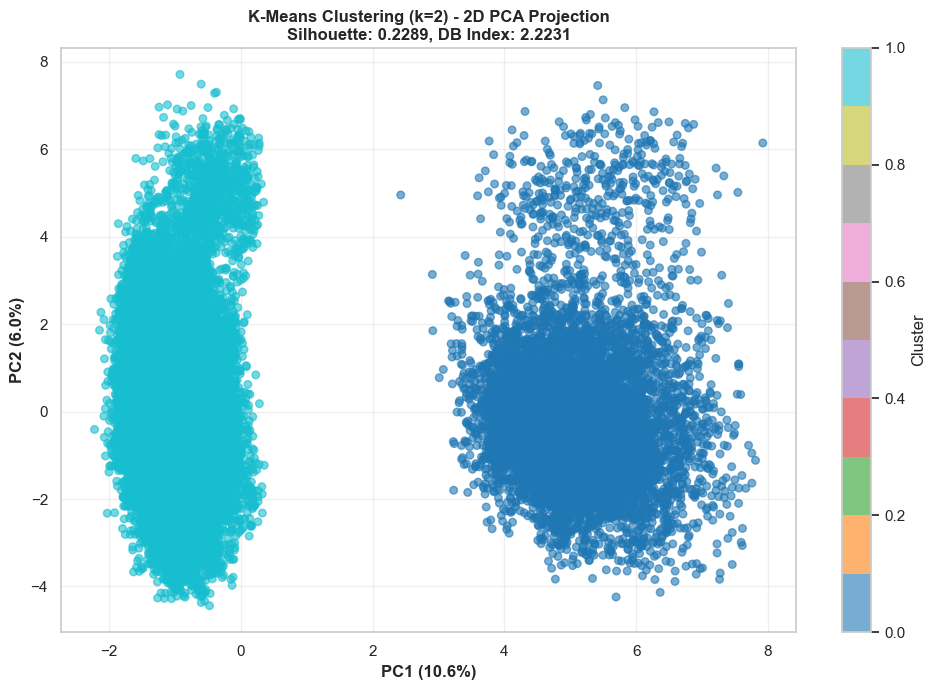

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score


def get_labels_from_clusters(kmeans_model, X):
    """
    returns cluster labels for each point given trained KMeansClustering model
    """
    centroids = kmeans_model.centroids
    labels = np.zeros(len(X), dtype=int)
    for i, x in enumerate(X):
        distances = np.linalg.norm(x - centroids, axis=1)
        labels[i] = np.argmin(distances)
    return labels


def compute_inertia(X, labels, centroids):
    """Compute inertia (within-cluster sum of squares)"""
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[i]) ** 2)
    return inertia



class KMeansClustering:
    def __init__(self, k, epsilon=1e-4, max_iter=500):
        self.k = k
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.centroids = None
        self.labels_ = None

    def initialize_centroids(self, X):
        """randomly pick k points as initial centroids"""
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[indices]

    def assign_clusters(self, X):
        """assign each point to the nearest centroid (vectorized)"""
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        """update centroids as mean of assigned points"""
        new_centroids = np.zeros_like(self.centroids)
        for i in range(self.k):
            points = X[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def fit(self, X):
        self.initialize_centroids(X)
        for iteration in range(self.max_iter):
            labels = self.assign_clusters(X)
            new_centroids = self.update_centroids(X, labels)
            shift = np.linalg.norm(self.centroids - new_centroids)
            if shift < self.epsilon:
                print(f"converged at iteration {iteration+1}")
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self



print("="*80)
print("K-MEANS CLUSTERING - PARAMETER TUNING")
print("="*80)

K_range = range(2, 3)
inertias = []
silhouette_scores = []

print("\nTesting different values of k...\n")

for k in K_range:
    print(f"k = {k}:")
    kmeans = KMeansClustering(k=k, epsilon=1e-9, max_iter=2000)
    model = kmeans.fit(X_array)
    labels = model.labels_
    inertia = compute_inertia(X_array, labels, model.centroids)
    sil_score = silhouette_score(X_array, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"  Inertia: {inertia:.2f}")
    print(f"  Silhouette Score: {sil_score:.4f}\n")

best_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("="*80)
print(f"OPTIMAL k = {best_k} (Silhouette Score: {best_silhouette:.4f})")
print("="*80)



print(f"\nFitting final K-Means model with k={best_k}...")
kmeans_final = KMeansClustering(k=best_k, epsilon=1e-9, max_iter=2000).fit(X_array)
labels_final = kmeans_final.labels_

# evaluation
silhouette = silhouette_score(X_array, labels_final)
db_index = davies_bouldin_score(X_array, labels_final)

print(f"\nFinal K-Means Results:")
print(f"  Number of clusters: {best_k}")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies–Bouldin Index: {db_index:.4f}")

print(f"\nCluster Sizes:")
cluster_counts = pd.Series(labels_final).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} samples ({100*count/len(labels_final):.1f}%)")




pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_array)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_final, cmap='tab10', s=30, alpha=0.6)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontweight='bold')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontweight='bold')
plt.title(f'K-Means Clustering (k={best_k}) - 2D PCA Projection\nSilhouette: {silhouette:.4f}, DB Index: {db_index:.4f}',
          fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(X_array, labels_final)
db_index = davies_bouldin_score(X_array, labels_final)

print(f"\nFinal Evaluation Metrics:")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies–Bouldin Index: {db_index:.4f}")



Final Evaluation Metrics:
  Silhouette Score: 0.2289
  Davies–Bouldin Index: 2.2231
